### Imports

In [1]:
#%pip install xarray

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KernelDensity

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

from sklearn.linear_model import LinearRegression

import xarray as xr
from sklearn.model_selection import GridSearchCV

### Data Visualisation For Whale Data

In [17]:
# Load dataset
data = pd.read_csv('obis_seamap_species_data.csv', encoding='latin1') 

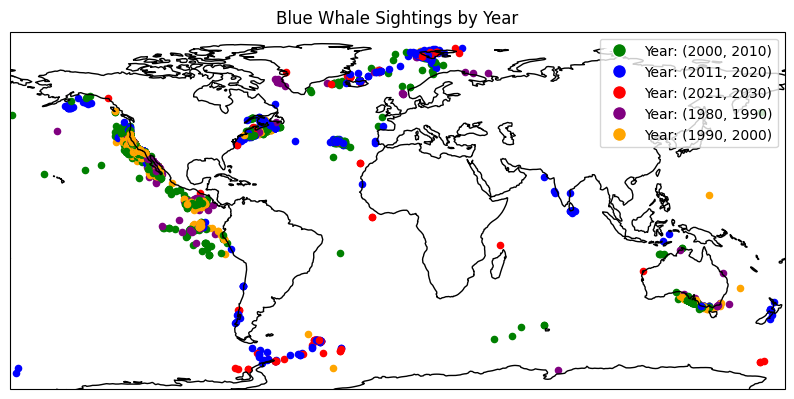

In [20]:
# Create a Cartopy plot with a world map background
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Convert the 'date_time' column to datetime objects
data['date_time'] = pd.to_datetime(data['date_time'])

# Add world map background with coastlines
ax.add_feature(cfeature.COASTLINE)

# Define a color mapping scheme for year ranges
color_mapping = {
    (1980, 1990): 'purple',
    (1990, 2000): 'orange',
    (2000, 2010): 'green',
    (2011, 2020): 'blue',
    (2021, 2030): 'red'  
}

# Create a scatter plot for each sighting
for index, row in data.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    date_time = row['date_time']
    
    # Extract the year from the date_time column
    year = date_time.year
    
    # Assign a color based on the year range
    marker_color = None
    for year_range, color in color_mapping.items():
        if year_range[0] <= year <= year_range[1]:
            marker_color = color
            break
    
    if marker_color:
        plt.scatter(longitude, latitude, c=marker_color, s=20, label=f'Year: {year}')

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Blue Whale Sightings by Year')

# Add a legend to the plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Year: {year}', markersize=10, markerfacecolor=color) for year, color in color_mapping.items()]
plt.legend(handles=legend_elements)

# Display the plot
plt.show()

    Year  Number of Sightings
0   1904                   30
1   1909                   33
2   1910                   26
3   1911                   15
4   1912                   15
..   ...                  ...
93  2019                  133
94  2020                  165
95  2021                   99
96  2022                  160
97  2023                  201

[98 rows x 2 columns]


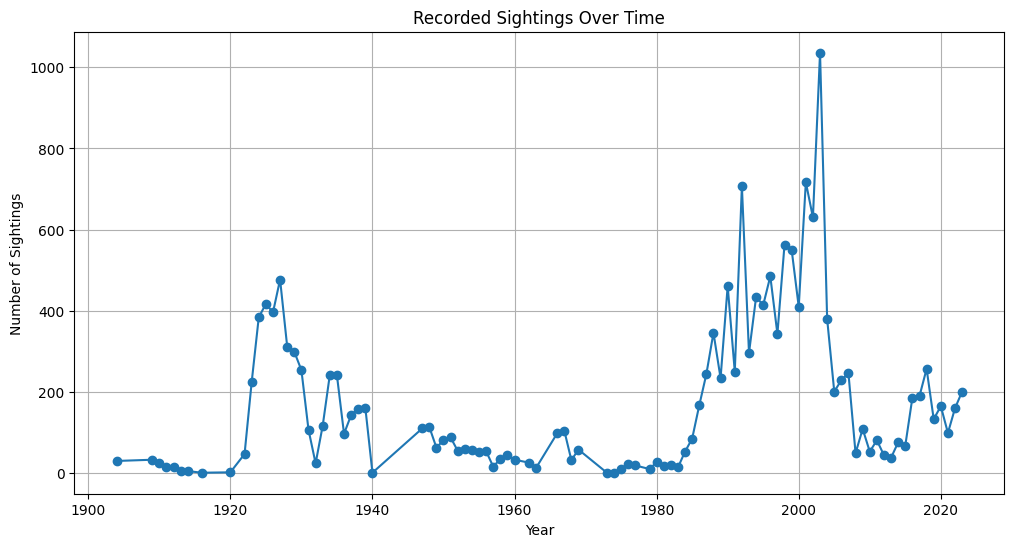

In [21]:
# Convert the 'date_time' column to datetime objects
data['date_time'] = pd.to_datetime(data['date_time'])

# Extract the year from the 'date_time' column
data['year'] = data['date_time'].dt.year

# Calculate the number of sightings per year
sightings_per_year = data['year'].value_counts().sort_index()

# Create a sightings table
sightings_table = sightings_per_year.reset_index()
sightings_table.columns = ['Year', 'Number of Sightings']
print(sightings_table)

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(sightings_per_year.index, sightings_per_year.values, marker='o')
plt.title('Recorded Sightings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(True)
plt.show()

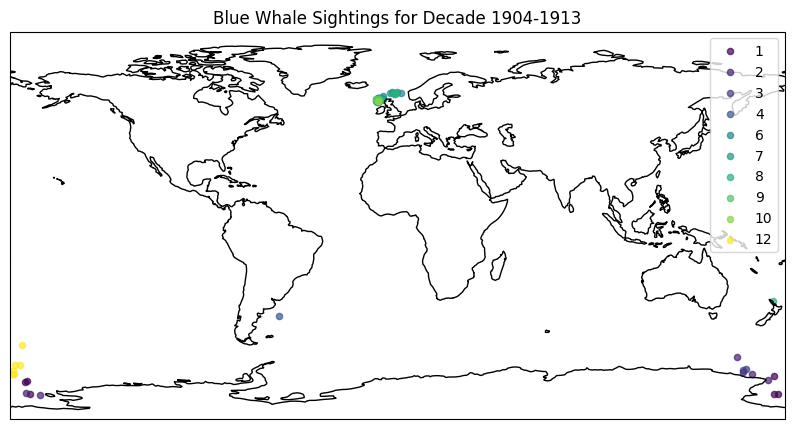

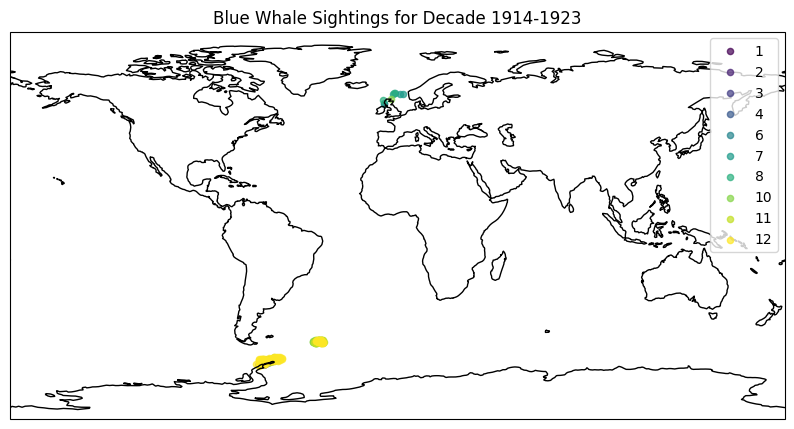

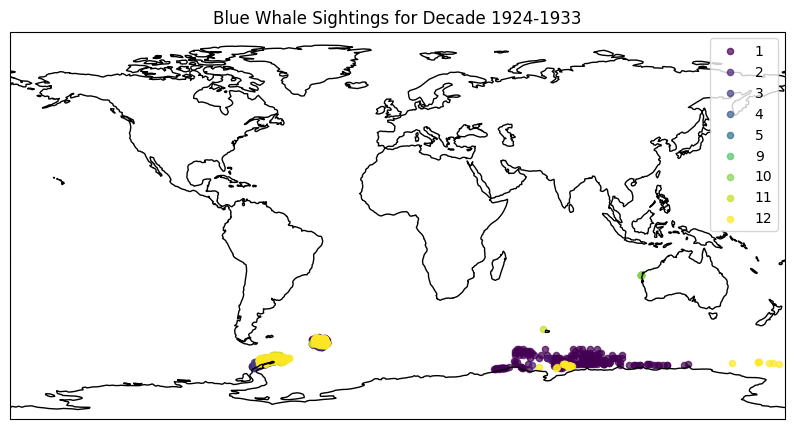

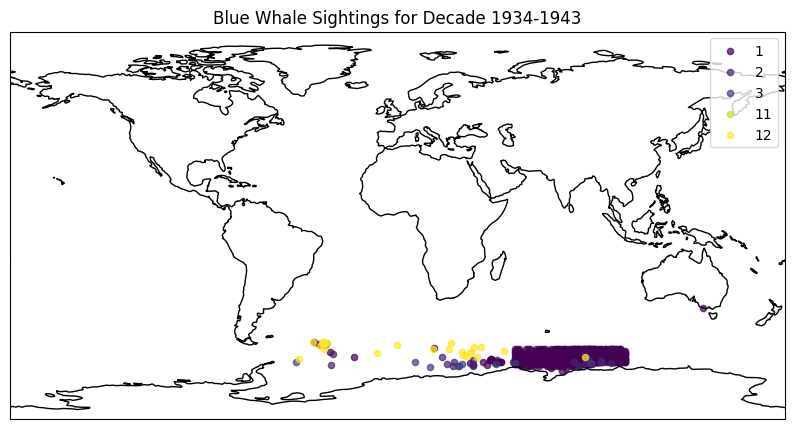

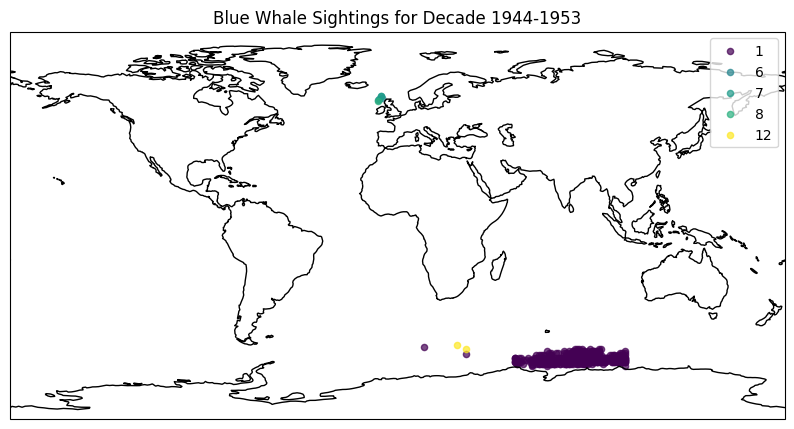

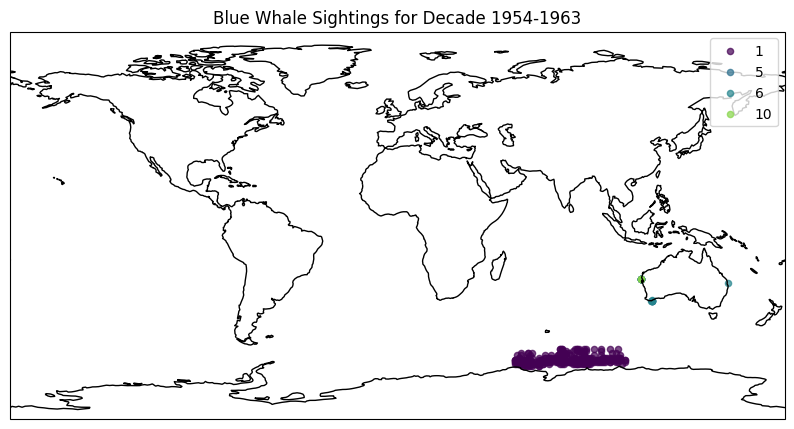

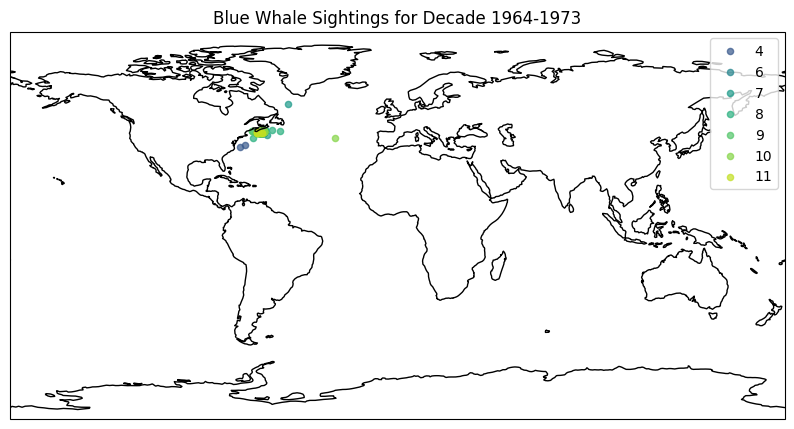

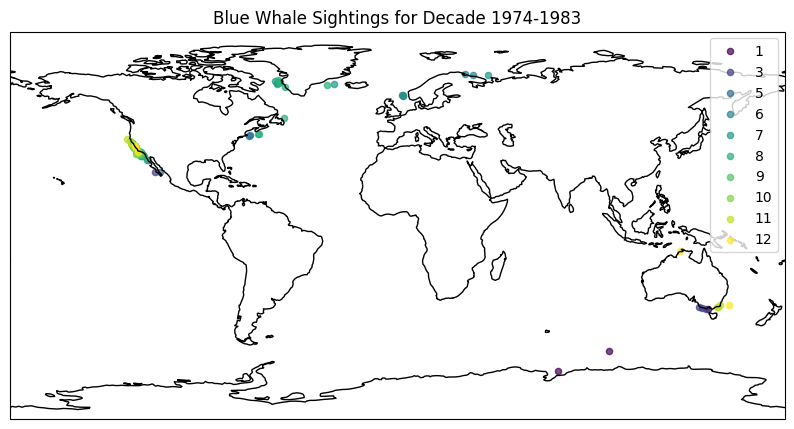

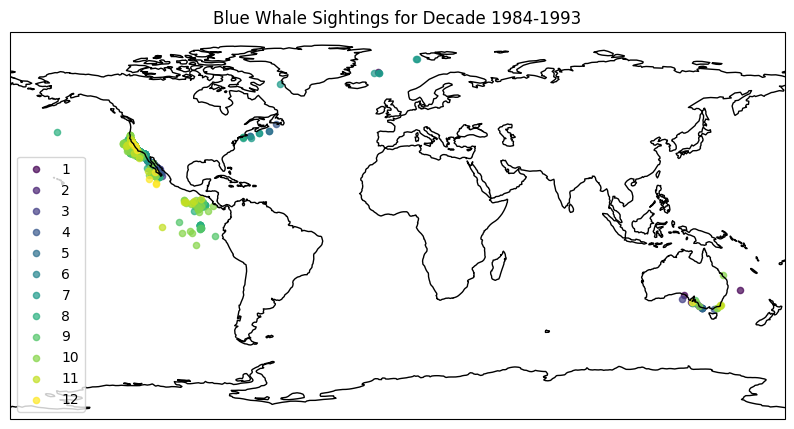

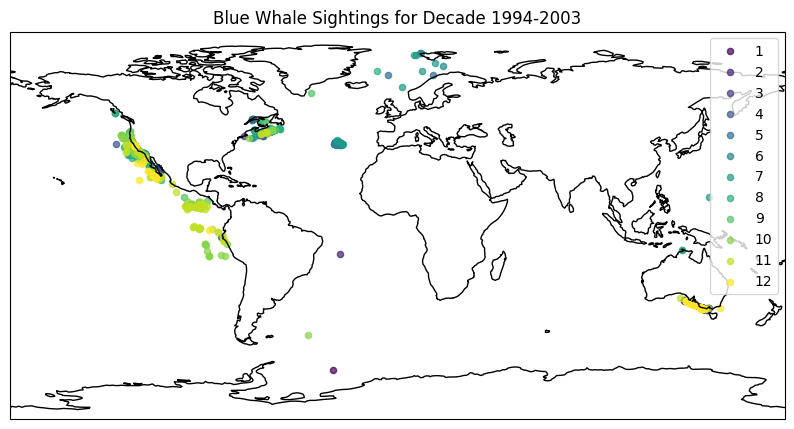

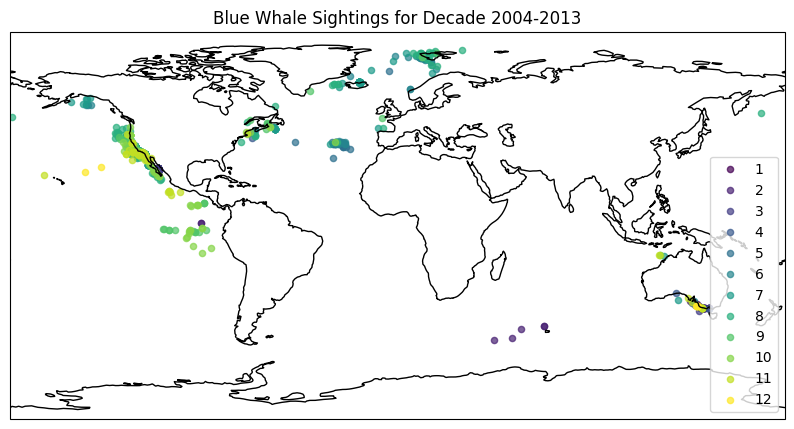

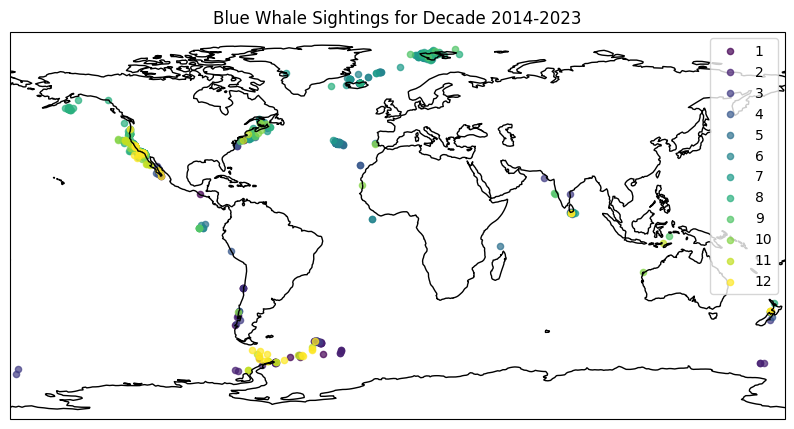

In [22]:
# Extract the year and month from the 'date_time' column
data['year'] = data['date_time'].dt.year
data['month'] = data['date_time'].dt.month

# Define the starting year of your dataset
start_year = data['year'].min()

# Define the interval for grouping years
year_interval = 10

# Create separate scatter plots for each decade with a world map background
while start_year <= data['year'].max():
    end_year = start_year + year_interval - 1
    
    # Filter the data for the current decade
    decade_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]
    
    # Check if there is data for the current decade
    if not decade_data.empty:
        plt.figure(figsize=(10, 6))
        colors = cm.viridis(np.linspace(0, 1, 12))
        
        # Create a Cartopy plot with a world map background
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -90, 90])
        ax.add_feature(cfeature.COASTLINE)
        
        for month in range(1, 13):
            month_data = decade_data[decade_data['month'] == month]
            if not month_data.empty:
                plt.scatter(
                    month_data['longitude'],
                    month_data['latitude'],
                    s=20,
                    label=f'{month}',
                    color=colors[month - 1],
                    alpha=0.7,
                    transform=ccrs.PlateCarree()
                )
        
        plt.title(f'Blue Whale Sightings for Decade {start_year}-{end_year}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Move to the next decade
    start_year += year_interval

/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/2468292366.py:12: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)
/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/2468292366.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)


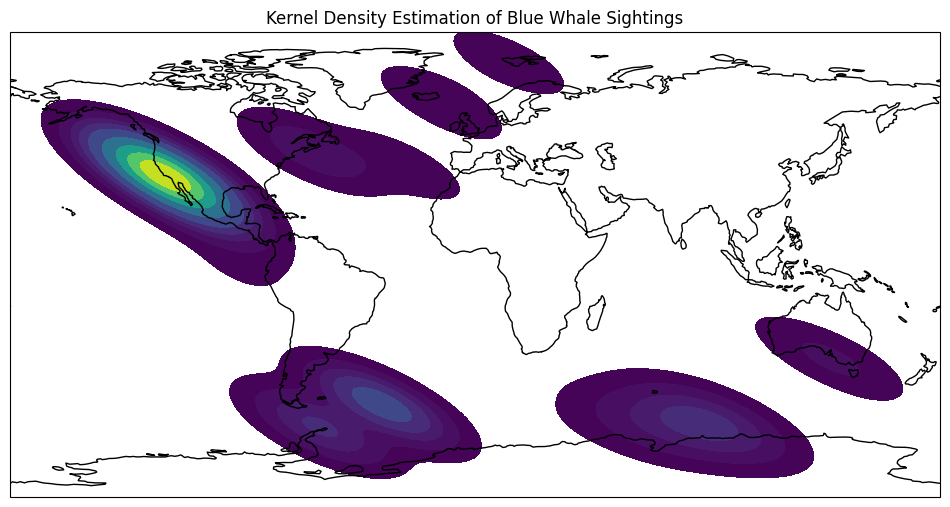

In [23]:
# Create a kernel density estimation plot for all the data

# Create a figure and axis with a world map background
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Add coastlines to the map for context
ax.add_feature(cfeature.COASTLINE)

# Create the KDE plot and overlay it on the map
sns.kdeplot(data=data, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)

plt.title('Kernel Density Estimation of Blue Whale Sightings')
plt.grid(True)
plt.show()

/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/1820326568.py:21: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_filtered, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)
/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/1820326568.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_filtered, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)


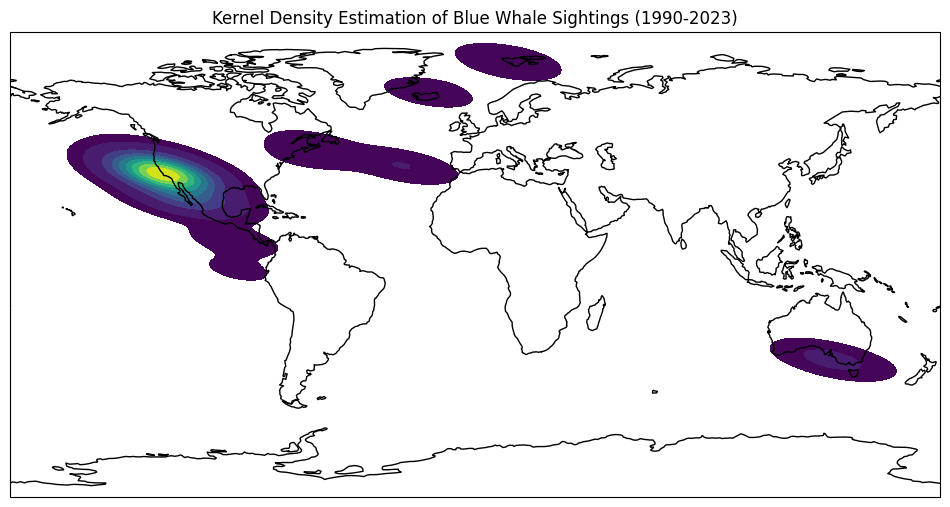

In [24]:
# Create a kernel density estimation plot for data from 1990-2023

# Convert 'date_time' to datetime if not already done
data['date_time'] = pd.to_datetime(data['date_time'])

# Extract year from date_time
data['year'] = data['date_time'].dt.year

# Filter data to include only years from 1990 to 2023
data_filtered = data[(data['year'] >= 1990) & (data['year'] <= 2023)]

# Create a figure and axis with a world map background
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Add coastlines to the map for context
ax.add_feature(cfeature.COASTLINE)

# Create the KDE plot with the filtered data and overlay it on the map
sns.kdeplot(data=data_filtered, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)

plt.title('Kernel Density Estimation of Blue Whale Sightings (1990-2023)')
plt.grid(True)
plt.show()


### Sea Surface Temperature Data

In [35]:
# Load the whale sightings data
#whale_data = pd.read_csv('obis_seamap_species_data.csv', encoding='latin1')

# Convert 'date_time' to datetime format and extract the date component
#whale_data['date_time'] = pd.to_datetime(whale_data['date_time'])
#whale_data['date'] = whale_data['date_time'].dt.date

# Load the SST data
#sst_data = xr.open_dataset('sst.mean.nc')

# Function to find the nearest value in an array
#def find_nearest(array, value):
    #array = np.asarray(array)
    #idx = (np.abs(array - value)).argmin()
    #return array[idx]

# Function to find the nearest latitude and longitude
#def find_nearest_lat_lon(lat_lon_array, lat_lon_point):
    #distances = cdist([lat_lon_point], lat_lon_array)
    #min_index = distances.argmin()
    #return lat_lon_array[min_index]

# Extract unique dates from the whale data for SST data extraction
#unique_dates = whale_data['date'].unique()

# Initialize a DataFrame to hold the extracted SST data
#sst_extracted = pd.DataFrame()

#for date in unique_dates:
    # Selecting the SST data for the nearest available date
    #nearest_sst_date = find_nearest(sst_data['time'].values, np.datetime64(date))
    #sst_for_date = sst_data['sst'].sel(time=nearest_sst_date)

    # Flatten the SST data and convert to a DataFrame
    #sst_df = sst_for_date.to_dataframe().reset_index()
    #sst_df['date'] = date  # Adding the whale sighting date

    # Concatenate to the main extracted DataFrame
    #sst_extracted = pd.concat([sst_extracted, sst_df])

#def find_nearest_sst(row, sst_data):
    # Find the nearest date in the SST data
    #nearest_date = find_nearest(sst_data['date'].unique(), row['date'])
    #sst_date_data = sst_data[sst_data['date'] == nearest_date]

    # Prepare lat-lon pairs for comparison
    #whale_lat_lon = [row['latitude'], row['longitude']]
    #sst_lat_lon = sst_date_data[['lat', 'lon']].values

    # Find the nearest latitude and longitude in the SST data
    #nearest_lat_lon = find_nearest_lat_lon(sst_lat_lon, whale_lat_lon)
    
    # Get the SST value for the nearest lat-lon
    #nearest_sst = sst_date_data[(sst_date_data['lat'] == nearest_lat_lon[0]) & 
                                #(sst_date_data['lon'] == nearest_lat_lon[1])]['sst'].iloc[0]
    #return nearest_sst

# Apply to a subset of whale data for testing
#test_output = whale_data.head().apply(lambda row: find_nearest_sst(row, sst_extracted), axis=1)
#print("Test output for a subset of whale data:")
#print(test_output)



Test output for a subset of whale data:
0    26.790009
1    25.429993
2    25.429993
3    18.600006
4          NaN
dtype: float32


In [39]:
# Apply find_nearest_sst function to the entire whale data DataFrame
#whale_data['nearest_sst'] = whale_data.apply(lambda row: find_nearest_sst(row, sst_extracted), axis=1)

# Display the first few rows of the DataFrame to verify
#print(whale_data.head())
#whale_data.to_csv('whale_data_with_sst.csv', index=False)

   dataset_id            row_id   latitude   longitude           species_name  \
0        1006         1006_1047  40.750000  -71.716667  BALAENOPTERA MUSCULUS   
1        1006         1006_1185  40.800000  -71.816667  BALAENOPTERA MUSCULUS   
2        1006         1006_1201  40.833333  -71.883333  BALAENOPTERA MUSCULUS   
3        1028           1028_85  37.770000 -130.590000                    075   
4   103150014  103150014_956586 -67.760002   74.410004  Balaenoptera musculus   

         scientific_name common_name  itis_tsn  group_size  series_id  ...  \
0  Balaenoptera musculus  Blue Whale    180528         1.0        NaN  ...   
1  Balaenoptera musculus  Blue Whale    180528         1.0        NaN  ...   
2  Balaenoptera musculus  Blue Whale    180528         1.0        NaN  ...   
3  Balaenoptera musculus  Blue Whale    180528         1.0        NaN  ...   
4  Balaenoptera musculus  Blue Whale    180528         NaN        NaN  ...   

  ds_type  platform                         

### Machine Learning Algorithms

In [3]:
# Load the dataset
df = pd.read_csv('whale_data_with_sst.csv', encoding='latin1')

# Use only the relevant columns and drop rows with missing values
df_relevant = df[['latitude', 'longitude', 'date_time', 'nearest_sst']].dropna()

# Convert 'date_time' to datetime
df_relevant['date_time'] = pd.to_datetime(df_relevant['date_time'])
df_relevant['year'] = df_relevant['date_time'].dt.year

# Filter data for years 1990 to 2023
df_relevant = df_relevant[(df_relevant['year'] >= 1990) & (df_relevant['year'] <= 2023)]

In [4]:
# Define the grid boundaries
min_longitude, max_longitude = df_relevant['longitude'].min(), df_relevant['longitude'].max()
min_latitude, max_latitude = df_relevant['latitude'].min(), df_relevant['latitude'].max()

# Initialize the grid for KDE
num_points = 50 

lon = np.linspace(min_longitude, max_longitude, num_points)
lat = np.linspace(min_latitude, max_latitude, num_points)
grid_lon, grid_lat = np.meshgrid(lon, lat)

# Calculate KDE for each year and store the results
years = df_relevant['year'].unique()
kde_scores_per_year = {}

for year in years:
    data_for_year = df_relevant[df_relevant['year'] == year][['longitude', 'latitude']]
    kde = KernelDensity(bandwidth=2.0, kernel='gaussian')
    kde.fit(data_for_year.values)
    kde_scores_on_grid = kde.score_samples(np.vstack((grid_lon.ravel(), grid_lat.ravel())).T)
    kde_scores_per_year[year] = kde_scores_on_grid.reshape(num_points, num_points)

In [5]:
# Sort the years to ensure correct lag calculations
sorted_years = sorted(kde_scores_per_year.keys())

# Define number of lag years
num_lags = 3

# Start from the (num_lags + 1)th year in sorted_years
filtered_years = sorted_years[num_lags:]

# Initialize a new dictionary for the filtered lag features
filtered_kde_lag_features = {}

for year in filtered_years:
    # Basic lag features: Previous years' KDEs
    kde_lags = [kde_scores_per_year[year - j].ravel() for j in range(1, num_lags + 1)]
    
    # More complex features
    current_year_kde_flat = kde_scores_per_year[year].ravel()
    previous_year_kde_flat = kde_scores_per_year[year - 1].ravel()

    # Average change between years (year-over-year difference)
    year_over_year_diff = current_year_kde_flat - previous_year_kde_flat

    # Long-term average (up to current year)
    long_term_average_flat = np.mean([kde_scores_per_year[y].ravel() for y in sorted_years if y < year], axis=0)

    # Difference from the long-term average
    diff_from_long_term = current_year_kde_flat - long_term_average_flat

    # Combine all features
    combined_features = np.hstack([np.hstack(kde_lags), year_over_year_diff, diff_from_long_term])
    filtered_kde_lag_features[year] = combined_features

# Convert the dictionary of filtered lag features to a DataFrame
lag_feature_df = pd.DataFrame.from_dict(filtered_kde_lag_features, orient='index')

# Define the feature matrix X and target vector y
X = lag_feature_df.values
y = np.array([kde_scores_per_year[year].ravel() for year in filtered_years])

print(X.shape)
print(y.shape)

(31, 12500)
(31, 2500)


### Linear Regression Model

In [11]:
# Convert the dictionary of filtered lag features to a DataFrame
lag_feature_df = pd.DataFrame.from_dict(filtered_kde_lag_features, orient='index')

# Define the feature matrix X and target vector y
X = lag_feature_df.values
y = np.array([kde_scores_per_year[year].ravel() for year in filtered_years])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define a multi-output regressor with Linear Regression
linear_regressor = LinearRegression()
multi_output_linear = MultiOutputRegressor(linear_regressor)

# Fit the model
multi_output_linear.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = multi_output_linear.predict(X_test)

# Evaluate the model (example: R^2 score for each output)
r2_scores_linear = [r2_score(y_test[:, i], y_pred_linear[:, i]) for i in range(y_test.shape[1])]
average_r2_score_linear = np.mean(r2_scores_linear)

mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print("R^2 scores for each output:", r2_scores_linear)
print("Average R^2 score (Linear Regression):", average_r2_score_linear)
print("Test Mean Squared Error (Linear Regression):", mse_linear)
print("Test Root Mean Squared Error (Linear Regression):", rmse_linear)
print("Test Mean Absolute Error (Linear Regression):", mae_linear)

R^2 scores for each output: [-8.218898999545454, -3.8130034183862795, -1.6708271827850791, -0.6219850529619737, -0.05419137219107606, 0.2093498312074884, 0.30228894474642987, 0.3393826229680901, 0.33320704254950795, 0.2724941105375597, 0.17205381989379942, 0.11064147406989322, 0.20818480687224106, 0.26030996340598767, 0.24066569948926753, 0.22989745528640804, 0.2630737379014796, 0.31553913645030895, 0.3254234674681906, 0.44224694630776673, 0.5545395248609892, 0.6439436589983552, 0.7448015475515875, 0.7620095106455684, 0.6570503350359863, 0.29631429859755953, 0.1631922988613569, 0.25458709155206816, 0.3733896425718227, 0.6268271318244398, 0.5819950572683383, -0.0652158265850995, -0.7315250953104775, -1.0530792531085202, -0.9354574940503544, -0.8092706445905975, -0.7123378482192817, -0.6339337100999807, -0.48494415002114044, -0.3710303335120888, -0.21797650994986872, -0.10182756649833347, -0.00847608238476183, 0.06931372780892908, 0.13751650211842226, 0.1941581869875436, 0.24719829357823

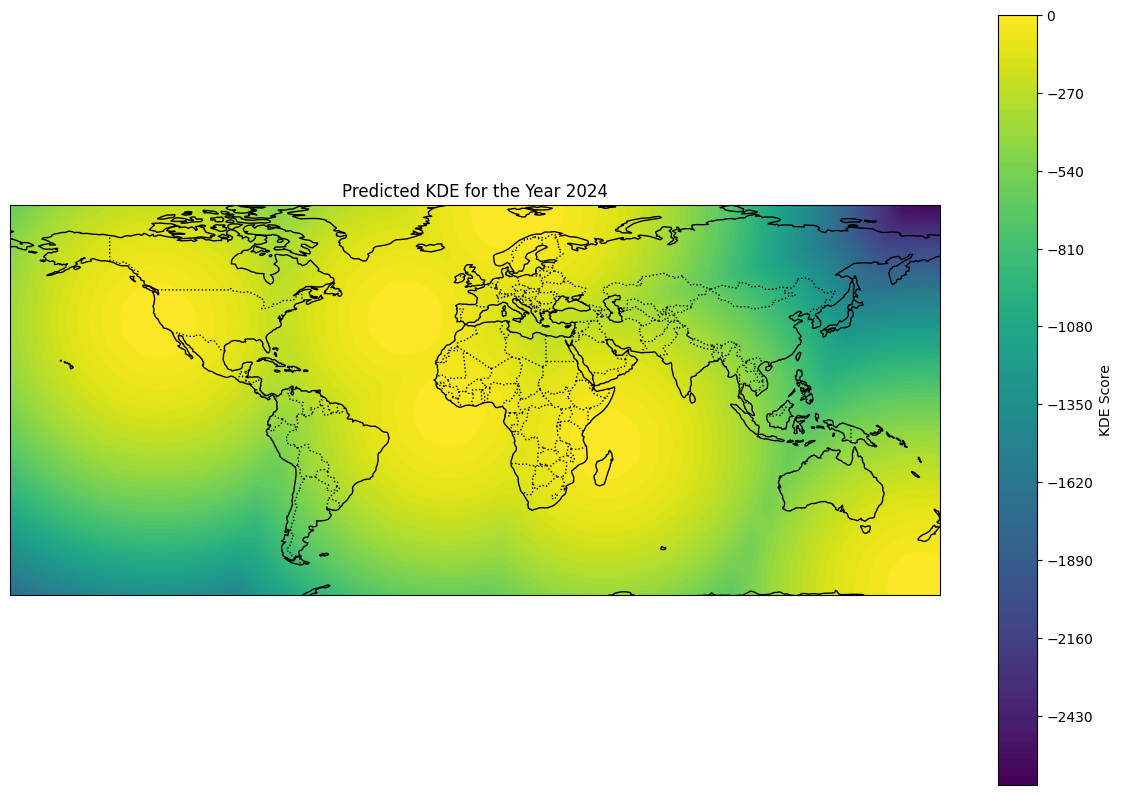

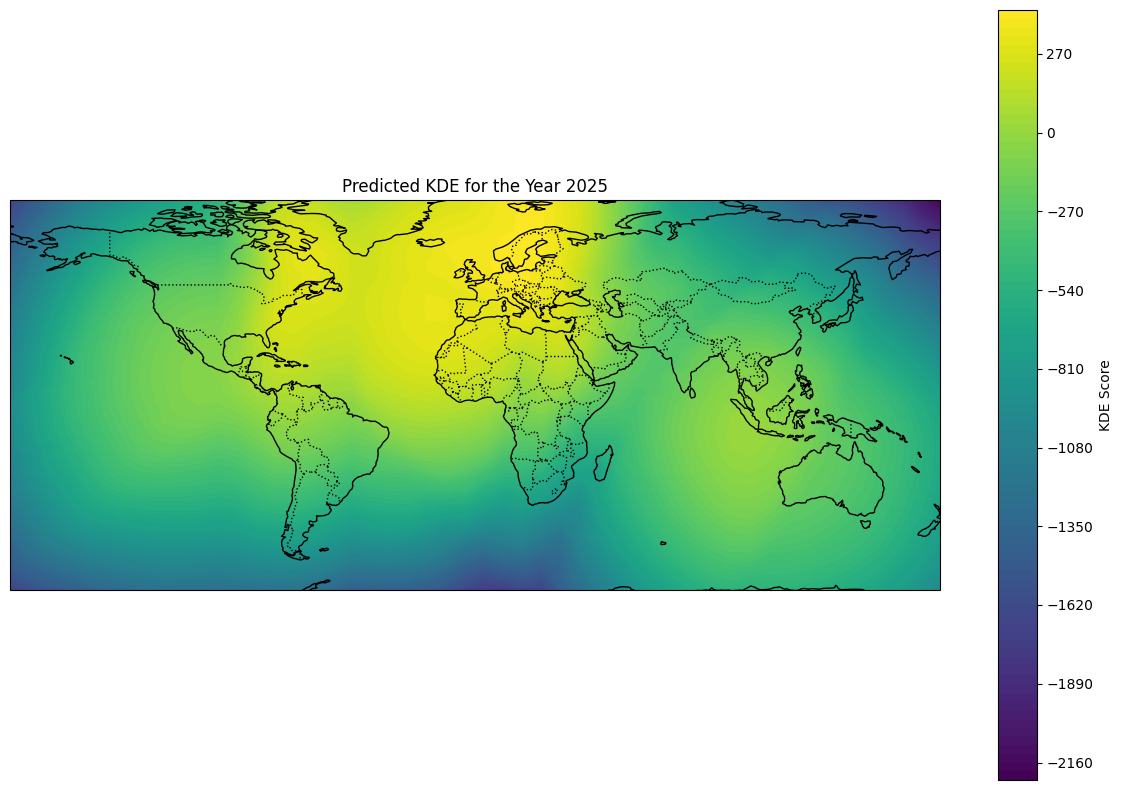

In [13]:
# Predict for 2024 and 2025
features_2024 = filtered_kde_lag_features[sorted_years[-1]].reshape(1, -1)
features_2025 = np.hstack([features_2024[0][len(features_2024[0])//num_lags:], np.zeros(len(features_2024[0])//num_lags)]).reshape(1, -1)

prediction_2024 = multi_output_linear.predict(features_2024).reshape(num_points, num_points)
prediction_2025 = multi_output_linear.predict(features_2025).reshape(num_points, num_points)

# Function to plot predictions on the world map
def plot_world_map(predictions, year):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude], crs=ccrs.PlateCarree())
    contour = ax.contourf(grid_lon, grid_lat, predictions, cmap='viridis', levels=100, transform=ccrs.PlateCarree())
    plt.colorbar(contour, label='KDE Score')
    plt.title(f'Predicted KDE for the Year {year}')
    plt.show()
    
# Plot predictions for 2024 and 2025
plot_world_map(prediction_2024, 2024)
plot_world_map(prediction_2025, 2025)

### Random Forest For Predicting Future Kernel Density Estimations

In [6]:
# Convert the dictionary of filtered lag features to a DataFrame
lag_feature_df = pd.DataFrame.from_dict(filtered_kde_lag_features, orient='index')

# Define the feature matrix X and target vector y
X = lag_feature_df.values
y = np.array([kde_scores_per_year[year].ravel() for year in filtered_years])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Initialize the Random Forest Regressor with desired parameters
rf = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Maximum depth of the tree
    random_state=42
)

# Wrap the Random Forest with MultiOutputRegressor
multi_output_rf = MultiOutputRegressor(rf)

# Fit the model to the training data
multi_output_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = multi_output_rf.predict(X_test)

# Evaluate the model (example: R^2 score for each output)
r2_scores_rf = [r2_score(y_test[:, i], y_pred_rf[:, i]) for i in range(y_test.shape[1])]
average_r2_score_rf = np.mean(r2_scores_rf)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("R^2 scores for each output:", r2_scores_rf)
print("Average R^2 score (Random Forest):", average_r2_score_rf)
print("Test Mean Squared Error (Random Forest):", mse_rf)
print("Test Root Mean Squared Error (Random Forest):", rmse_rf)
print("Test Mean Absolute Error (Random Forest):", mae_rf)

R^2 scores for each output: [-1.807232575644651, -1.3540554120878854, 0.18344932136354253, -0.06180410707757944, 0.6965220423158722, 0.6678307683946505, 0.7563629968040104, 0.7514174964109253, 0.7054644395192606, 0.6047591812709949, 0.9152843546936086, 0.9501937073282629, 0.9723534644268341, 0.9836895441328459, 0.9377772172802059, 0.9075586140513886, 0.8821055645555584, 0.8903213683072206, 0.8483801523744835, 0.7406418315514403, 0.7207790055937007, 0.5606907747569971, 0.6143505206684539, 0.6565904577826799, 0.5702812358238225, 0.6188641349029615, 0.6256995881629253, 0.5654251778532615, 0.5933370335460304, 0.7416546687086569, 0.6398626164749626, 0.22114028815237396, -0.18902296517868877, -0.40489195861870697, -0.6247072492468853, -0.7863670348810785, -0.8741118037688844, -0.9218079660059801, -0.9658047730676731, -1.0043132253654643, -1.038963416655705, -1.0223102581359567, -0.9455987955366236, -1.0485409811846824, -0.9994245307573111, -1.116263833718655, -1.082542555157013, -1.124191916

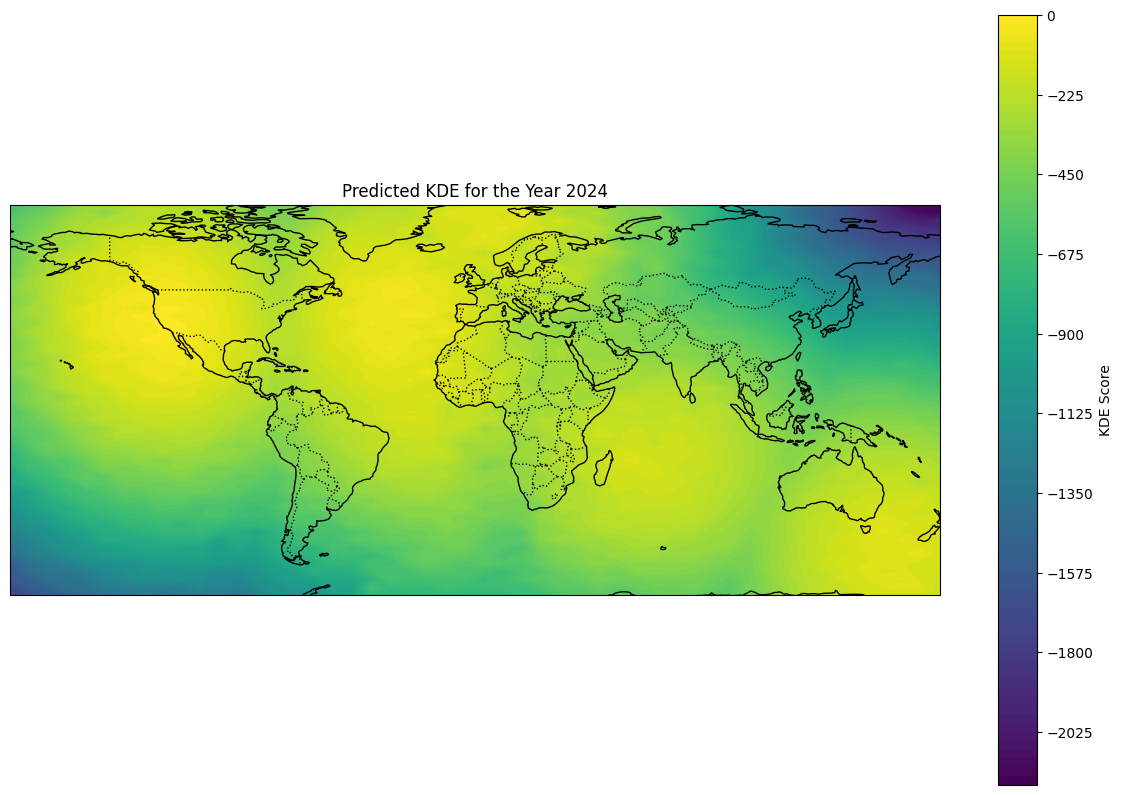

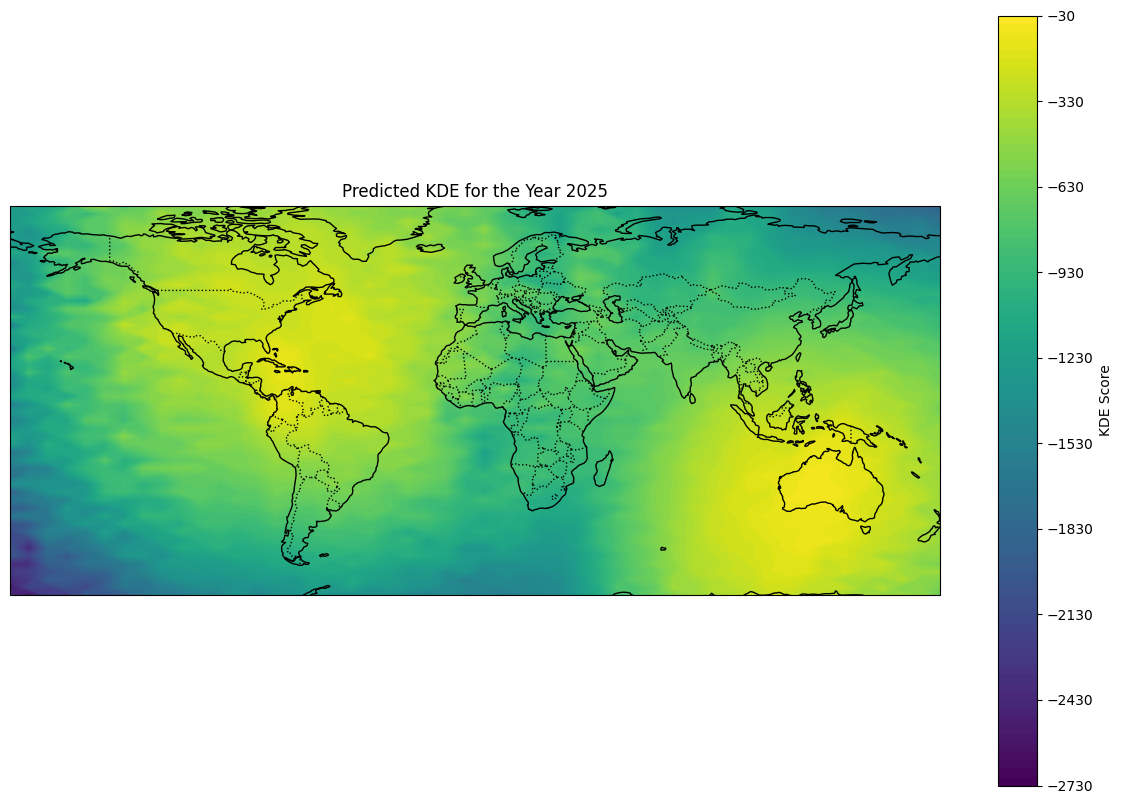

In [14]:
# Get the most recent year's features for prediction
most_recent_year_features = filtered_kde_lag_features[sorted_years[-1]]

# For 2024, use the most recent year's features directly
features_2024 = most_recent_year_features

# Shift each lag by one year and assume the most recent year (which we don't have data for) as zeros
features_2025 = np.hstack([most_recent_year_features[len(most_recent_year_features)//num_lags:], np.zeros(len(most_recent_year_features)//num_lags)])

# Reshape for the model's input
features_2024 = features_2024.reshape(1, -1)
features_2025 = features_2025.reshape(1, -1)

# Predict for 2024 and 2025
prediction_2024 = multi_output_rf.predict(features_2024).reshape(num_points, num_points)
prediction_2025 = multi_output_rf.predict(features_2025).reshape(num_points, num_points)

# Plot predictions for 2024 and 2025
plot_world_map(prediction_2024, 2024)
plot_world_map(prediction_2025, 2025)

### XGBoost With Multi Output Regression For Predicting Future Kernel Densities

In [ ]:
# Define the feature matrix X and target vector y
X = lag_feature_df.values[:-1]  # Use all but the last year for training
y = np.array([kde_scores_per_year[year].ravel() for year in sorted_years[num_lags:-1]])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define a multi-output regressor with XGBoost
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
multi_output_xgboost = MultiOutputRegressor(xgb_regressor)

# Fit the model
multi_output_xgboost.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_output_xgboost.predict(X_test)

# Evaluate the model (example: R^2 score for each output)
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
print("R^2 scores for each output:", r2_scores)

# Calculate regression metrics on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
average_r2_score = sum(r2_scores) / len(r2_scores)

print("Average R^2 score:", average_r2_score)

# Print regression metrics
print(f"Test Mean Squared Error: {mse}")
print(f"Test Root Mean Squared Error: {rmse}")
print(f"Test Mean Absolute Error: {mae}")

R^2 scores for each output: [-78.50538823169393, -42.07767518087764, -27.70645895278749, -15.557346484503789, -9.086373149110551, -5.598587916166229, -3.9599033351563033, -2.1930770735339102, -0.6660458693633733, -0.20246129622047437, 0.28953955001565757, 0.6045508064765751, 0.7489319032720743, 0.7267000070842576, 0.6610953119153131, 0.5799750882507411, 0.8712063061462099, 0.8243257239444948, 0.7696946669194844, 0.7885314973376505, 0.6352134841691102, 0.5934240017060686, 0.7004809236240516, 0.7237649700844833, 0.8176774145491943, 0.7112011799699514, 0.561988648317377, 0.1685985009587605, 0.6838181250419719, 0.7174155414239849, 0.5334841523599112, 0.2476510667301436, -0.17328680742838887, -1.0134915164984322, -0.8382960226381713, -0.7484309962862121, -1.0089589832570858, -0.9381936878630701, -0.9816691330159573, -1.0533290953916987, -1.0976038129440182, -1.0601374330220361, -1.0368942878935443, -1.1589628335017759, -1.161174872230518, -1.1968393698903013, -1.2457106848269595, -1.2389557

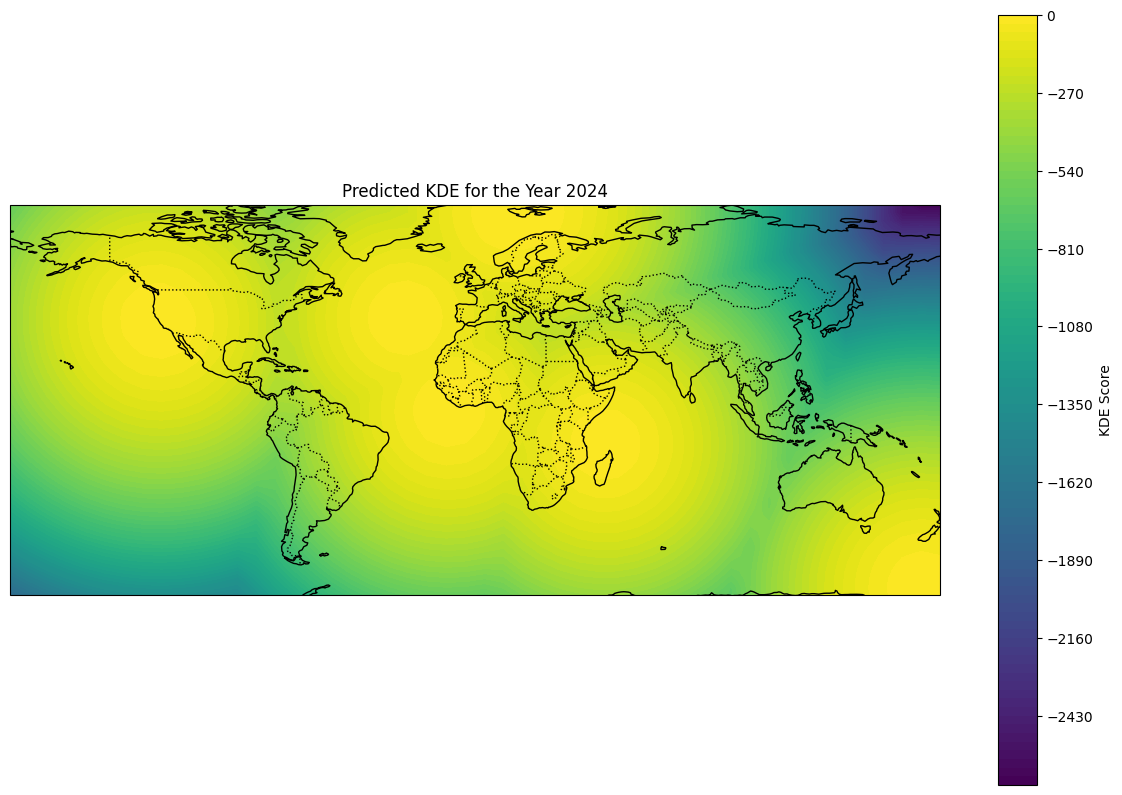

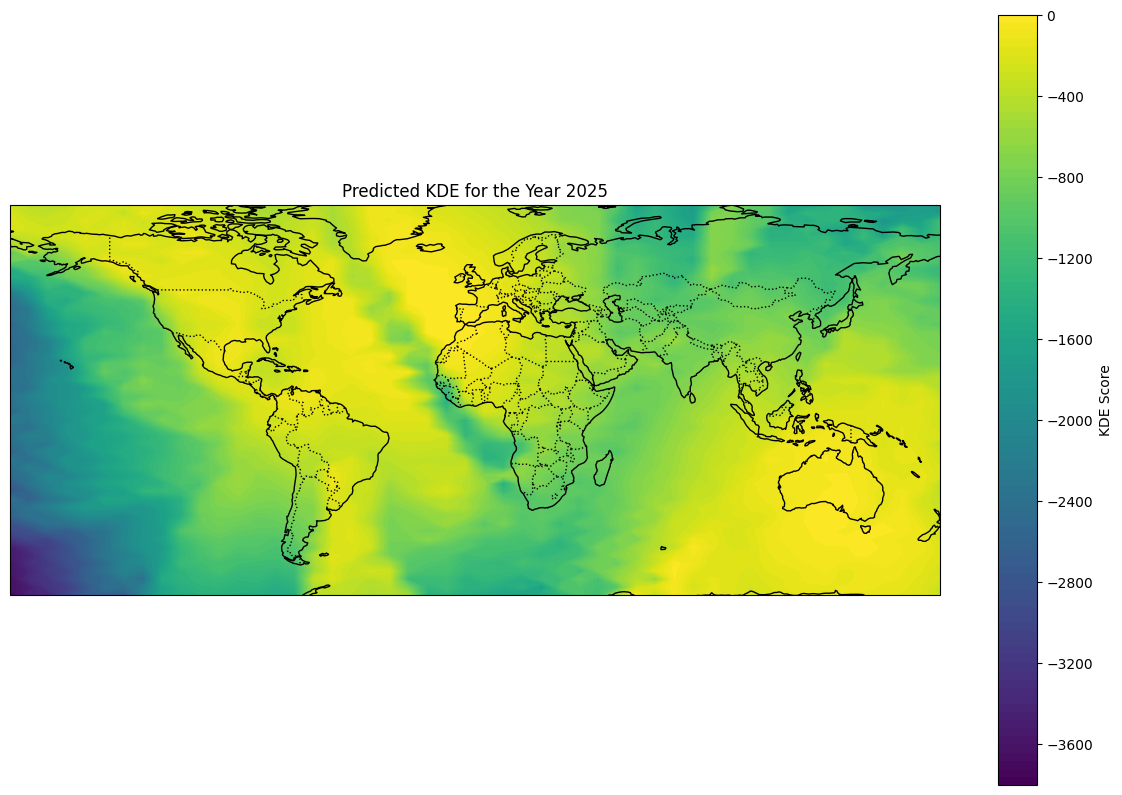

In [15]:
# Predict for 2024 and 2025
features_2024 = filtered_kde_lag_features[sorted_years[-1]].reshape(1, -1)
features_2025 = np.hstack([features_2024[0][len(features_2024[0])//num_lags:], np.zeros(len(features_2024[0])//num_lags)]).reshape(1, -1)

prediction_2024 = multi_output_xgboost.predict(features_2024).reshape(num_points, num_points)
prediction_2025 = multi_output_xgboost.predict(features_2025).reshape(num_points, num_points)

# Plot predictions for 2024 and 2025
plot_world_map(prediction_2024, 2024)
plot_world_map(prediction_2025, 2025)

### Model Comparisons

/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/37675236.py:24: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=year_data, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)
/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/37675236.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=year_data, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)
/var/folders/2q/3vc9gw4n5r50vw77lmgbwx5m0000gn/T/ipykernel_22789/37675236.py:24: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=year_data, x='longitude', y='latitude', cmap

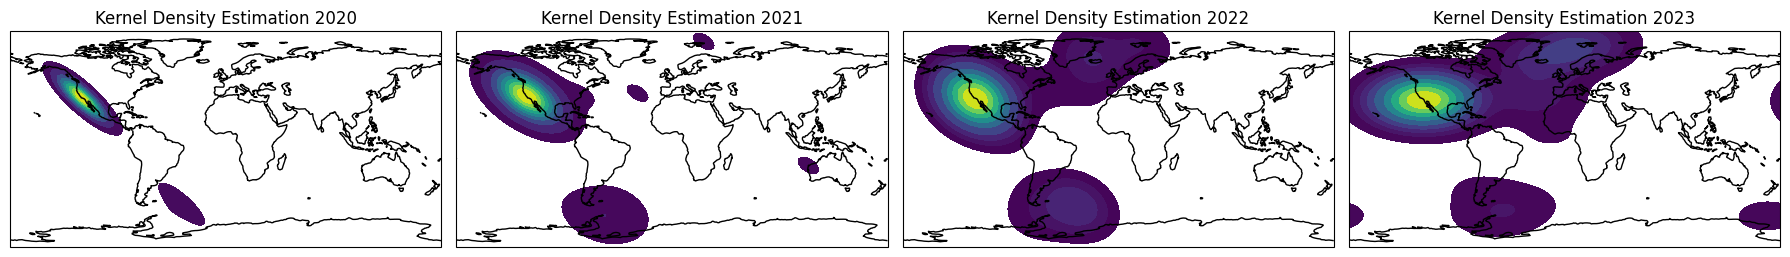

In [25]:
# Define years of interest
years = [2020, 2021, 2022, 2023]

# Create a figure with multiple subplots in one row
fig, axs = plt.subplots(1, len(years), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Ensure axs is always a list, even for a single subplot
if len(years) == 1:
    axs = [axs]

# Set common map extent and features for all subplots
for ax in axs:
    ax.set_extent([-180, 180, -90, 90])
    ax.add_feature(cfeature.COASTLINE)

# Create and plot KDE for each year
for ax, year in zip(axs, years):
    ax.set_title(f'Kernel Density Estimation {year}')

    # Filter data for the specific year
    year_data = data[data['year'] == year]

    # Create the KDE plot for the specific year and overlay it on the map
    sns.kdeplot(data=year_data, x='longitude', y='latitude', cmap="viridis", shade=True, shade_lowest=False, ax=ax)

plt.tight_layout()
plt.show()

In [26]:
# Predict for 2024 and 2025 using Linear Regression model
prediction_2024_linear = multi_output_linear.predict(features_2024).reshape(num_points, num_points)
prediction_2025_linear = multi_output_linear.predict(features_2025).reshape(num_points, num_points)

# Predict for 2024 and 2025 using Random Forest model
prediction_2024_rf = multi_output_rf.predict(features_2024).reshape(num_points, num_points)
prediction_2025_rf = multi_output_rf.predict(features_2025).reshape(num_points, num_points)

# Predict for 2024 and 2025 using XGBoost model
prediction_2024_xgboost = multi_output_xgboost.predict(features_2024).reshape(num_points, num_points)
prediction_2025_xgboost = multi_output_xgboost.predict(features_2025).reshape(num_points, num_points)


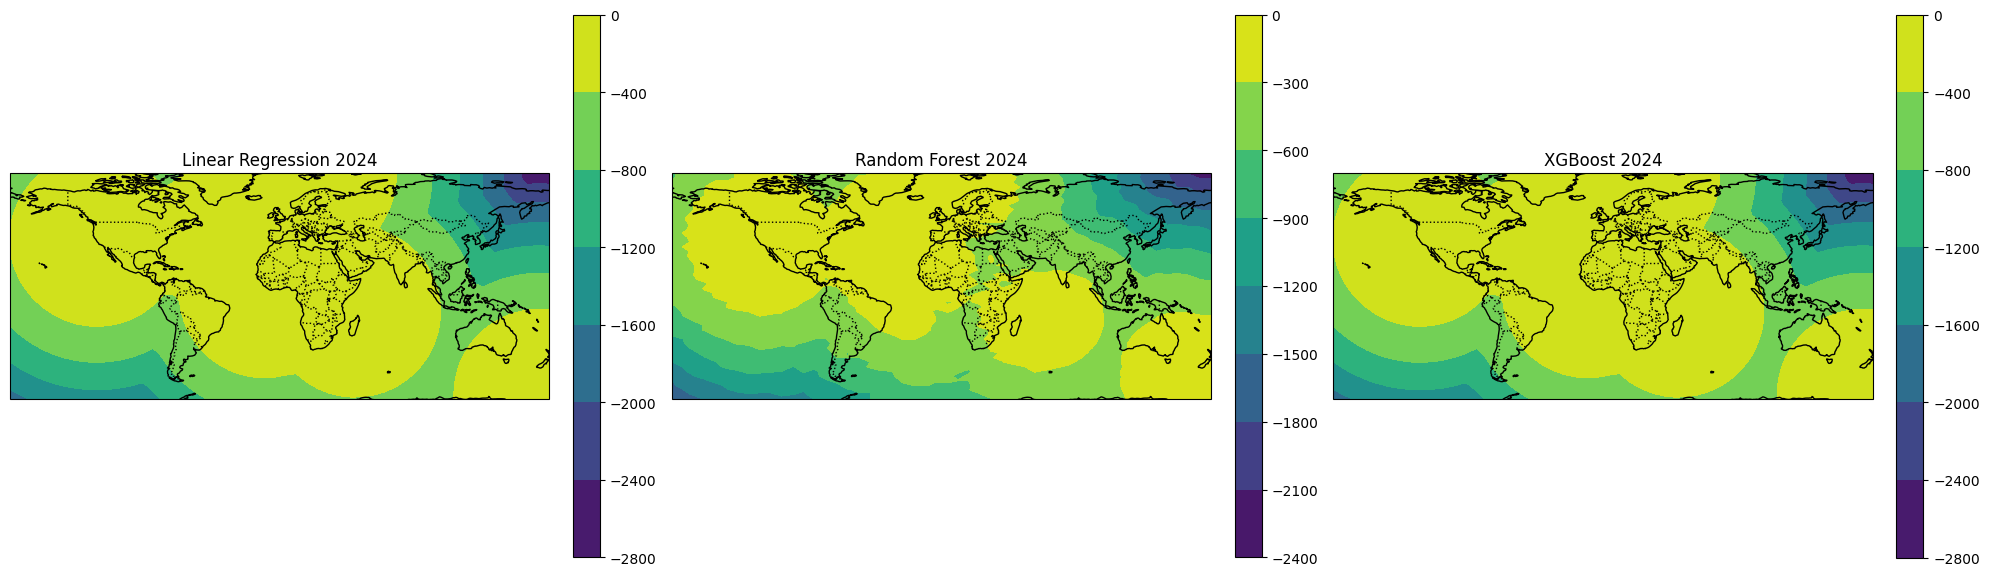

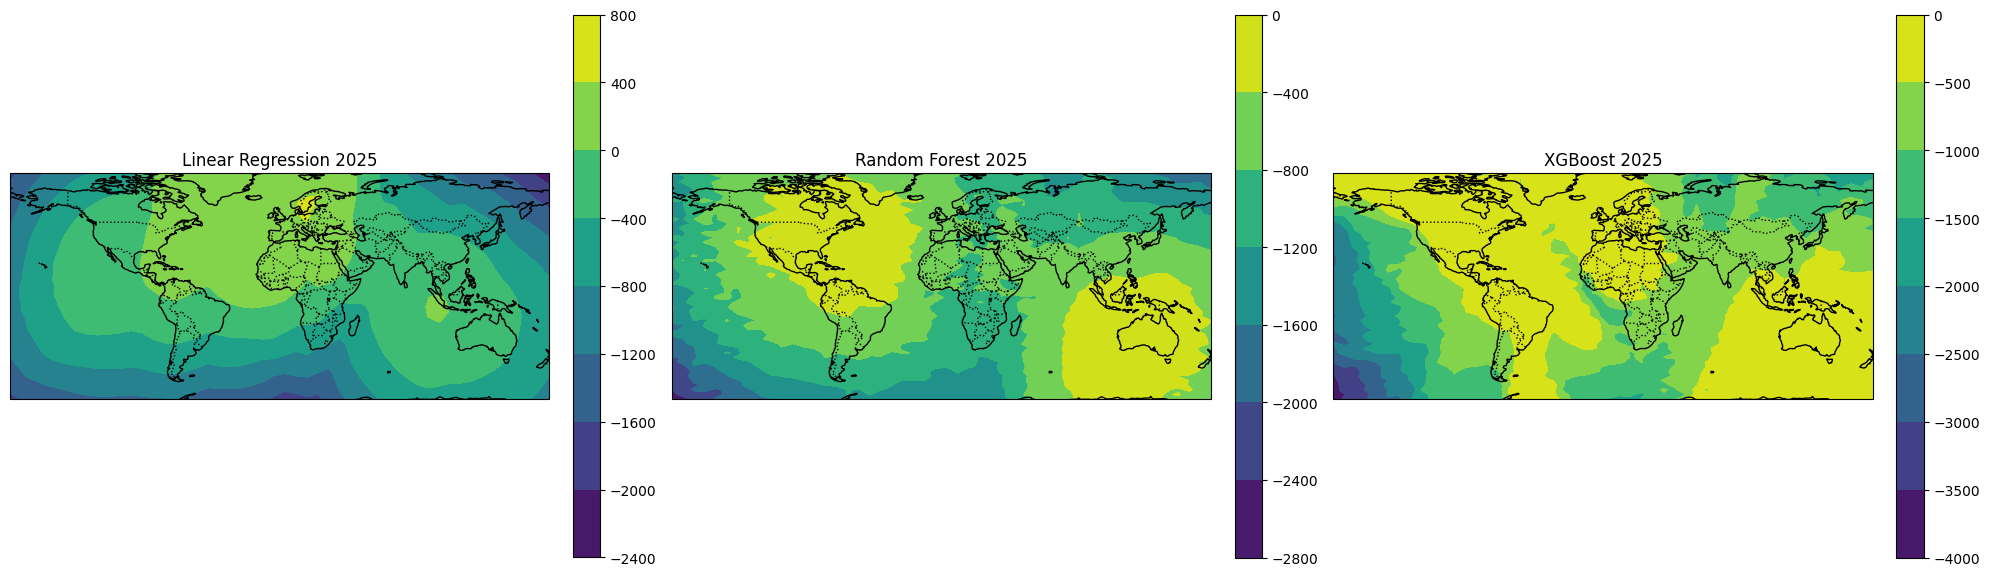

In [27]:
# Define a function to create a single map subplot
def create_map_subplot(ax, predictions, title, grid_lon, grid_lat):
    ax.set_title(title)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    contour = ax.contourf(grid_lon, grid_lat, predictions, cmap='viridis', transform=ccrs.PlateCarree())
    return contour

# Create a figure for the 2024 predictions
fig_2024 = plt.figure(figsize=(20, 6))

# Subplots for 2024
ax1_2024 = fig_2024.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
contour1_2024 = create_map_subplot(ax1_2024, prediction_2024_linear, 'Linear Regression 2024', grid_lon, grid_lat)

ax2_2024 = fig_2024.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
contour2_2024 = create_map_subplot(ax2_2024, prediction_2024_rf, 'Random Forest 2024', grid_lon, grid_lat)

ax3_2024 = fig_2024.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
contour3_2024 = create_map_subplot(ax3_2024, prediction_2024_xgboost, 'XGBoost 2024', grid_lon, grid_lat)

# Colorbars for 2024
fig_2024.colorbar(contour1_2024, ax=ax1_2024, orientation='vertical', fraction=0.046, pad=0.04)
fig_2024.colorbar(contour2_2024, ax=ax2_2024, orientation='vertical', fraction=0.046, pad=0.04)
fig_2024.colorbar(contour3_2024, ax=ax3_2024, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Create a figure for the 2025 predictions
fig_2025 = plt.figure(figsize=(20, 6))

# Subplots for 2025
ax1_2025 = fig_2025.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
contour1_2025 = create_map_subplot(ax1_2025, prediction_2025_linear, 'Linear Regression 2025', grid_lon, grid_lat)

ax2_2025 = fig_2025.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
contour2_2025 = create_map_subplot(ax2_2025, prediction_2025_rf, 'Random Forest 2025', grid_lon, grid_lat)

ax3_2025 = fig_2025.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
contour3_2025 = create_map_subplot(ax3_2025, prediction_2025_xgboost, 'XGBoost 2025', grid_lon, grid_lat)

# Colorbars for 2025
fig_2025.colorbar(contour1_2025, ax=ax1_2025, orientation='vertical', fraction=0.046, pad=0.04)
fig_2025.colorbar(contour2_2025, ax=ax2_2025, orientation='vertical', fraction=0.046, pad=0.04)
fig_2025.colorbar(contour3_2025, ax=ax3_2025, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()  # Adjust the layout for 2025
plt.show()
